In [ ]:
# To identify intergranular lanes, granules, and sunspots by Supervised machine learning (decision trees)

# In this notebook I will be applying the Decision tree, one method of supervised machine learning to classify a solar region into different features.

In [2]:
from google.colab import drive
drive.mount('drive')

p_data = '/content/drive/MyDrive/Colab Notebooks/'

Mounted at drive


In [ ]:
## importing libraries
!pip install pyfits
import pyfits
import matplotlib.pyplot as plt
import os


In [7]:
file = '0051170001_rte_data_products.fits'
data_phi = pyfits.getdata(os.path.join(p_data+file)) 

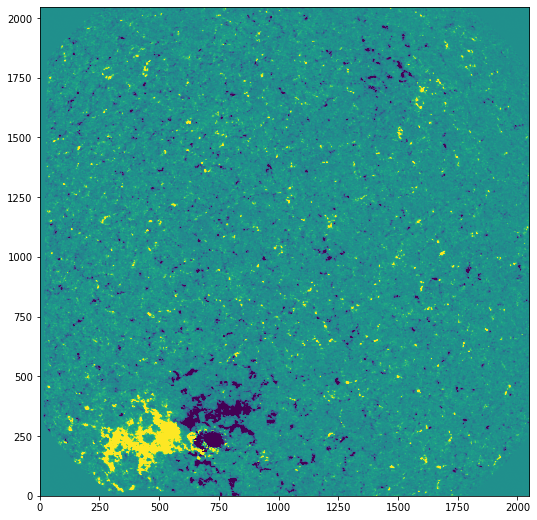

In [9]:
plt.figure(figsize=(12,9))
plt.imshow(data_phi[5,:,:],origin='lower',vmin=-50,vmax=50)

In [10]:
data_phi.shape

(6, 2048, 2048)

The image file we have is that of a forming sunspot from the `Polarimetric and Helioseismic Imager (PHI)` on the `Solar Orbiter mission`. The target is imaged in six different physical quantitites, named bands:

|Index|Band|Unit|
|------------|----------------|-----------------|
|0|Continuum intensity|--|
|1|Magnetic Field strength|(G)|
|2|Inclination angle of the vector magnetic field|(degree)|
|3|Azimuth of the vector magnetic field|(degree)|
|4|Line of sight velocity|(m/s)|
|5|Line of sight magnetic field|(G)|


#Preparing the data:
We use ImageJ to prepare the training data points. We choose 30 pixels for each class. The classes are those for `Negative polarity sunspot`, `positive polarity sunspot`, `positive polarity network`, and `negative polarity network`.
The resulting coordinates for each class are saved in tabular data and loaded as follows:

In [78]:
pos_sun = np.loadtxt(p_data+'sunspot_pos.txt',dtype='float').astype('int')
neg_sun = np.loadtxt(p_data+'sunspot_neg.txt',dtype='float').astype('int')
pos_net = np.loadtxt(p_data+'network_pos.txt',dtype='float').astype('int')
neg_net = np.loadtxt(p_data+'network_neg.txt',dtype='float').astype('int')

Now we want to stack all the pixel position of each class in all bands:

In [95]:
X_pos_sun = []
for i in range(channels):
  temp = (data_phi[i,:,:])[pos_sun[:,3],pos_sun[:,2]]
  X_pos_sun.append(temp)

In [96]:
np.asarray(X_pos_sun).shape

(6, 30)

In [97]:
data_phi[5,:,:][pos_sun[:,3],pos_sun[:,2]]

array([210.37986666, 246.09261049, 328.77560008, 312.15448498,
       298.30523137, 663.58462976, 177.87848111,  61.40432142,
       160.84656543, 125.11209957, 167.45951436, 105.98442044,
       116.5775461 , 267.98846077, 866.91390414,  95.04750131,
       316.40169948,  53.24076046, 236.63929979, 363.72441448,
       115.50044442, 268.94110022, 153.30458118, 200.95567709,
       152.28047976, 224.01643388, 563.33202317, 464.93797478,
       231.29620599,  98.3239396 ])

In [98]:
pos_sun[:,1]

array([210, 246, 531, 200, 240, 663, 174,  90, 358, 125, 218, 101, 133,
       418, 689,  84, 316,  70, 398, 363, 125, 311, 153, 200, 152, 215,
       596, 516, 231,  74])

In [113]:
X_pos_sun = np.stack(X_pos_sun).T

In [100]:
X_neg_sun = []
for i in range(channels):
  temp = (data_phi[i,:,:])[neg_sun[:,3],neg_sun[:,2]]
  X_neg_sun.append(temp)

In [114]:
X_neg_sun=np.stack(X_neg_sun).T

In [104]:
X_pos_net = []
for i in range(channels):
  temp = (data_phi[i,:,:])[pos_net[:,3],pos_net[:,2]]
  X_pos_net.append(temp)

In [111]:
X_pos_net = np.stack(X_pos_net).T

In [106]:
X_neg_net = []
for i in range(channels):
  temp = (data_phi[i,:,:])[neg_net[:,3],neg_net[:,2]]
  X_neg_net.append(temp)

In [112]:
X_neg_net = np.stack(X_neg_net).T

Now we will stack them all in one array:

In [115]:
X = np.vstack((X_pos_sun, X_neg_sun, X_pos_net, X_neg_net))

The final shape of the input array of our training data is all the data points belonging to different classes in all six bands:

In [116]:
X.shape

(120, 6)

The output should be a stack of labels ranging from 1 to 4:

|Index|Class|
|-------|-----------
|1| Positive polarity Sunspot
|2| Negative polarity Sunspot
|3| Positive polarity network
|4| Negative polarity network

In [119]:
Y=np.vstack((np.ones((X_pos_sun.shape[0], 1)),
             2*np.ones((X_neg_sun.shape[0], 1)),
             3*np.ones((X_pos_net.shape[0], 1)),
             4*np.ones((X_neg_net.shape[0], 1))))

Y.shape

(120, 1)

In [122]:
import sklearn
from sklearn.tree import DecisionTreeClassifier

Estimating the model by providing the labelled data:

In [123]:
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(X,np.ravel(Y))

DecisionTreeClassifier(max_depth=10)

In [124]:
from sklearn.tree import plot_tree

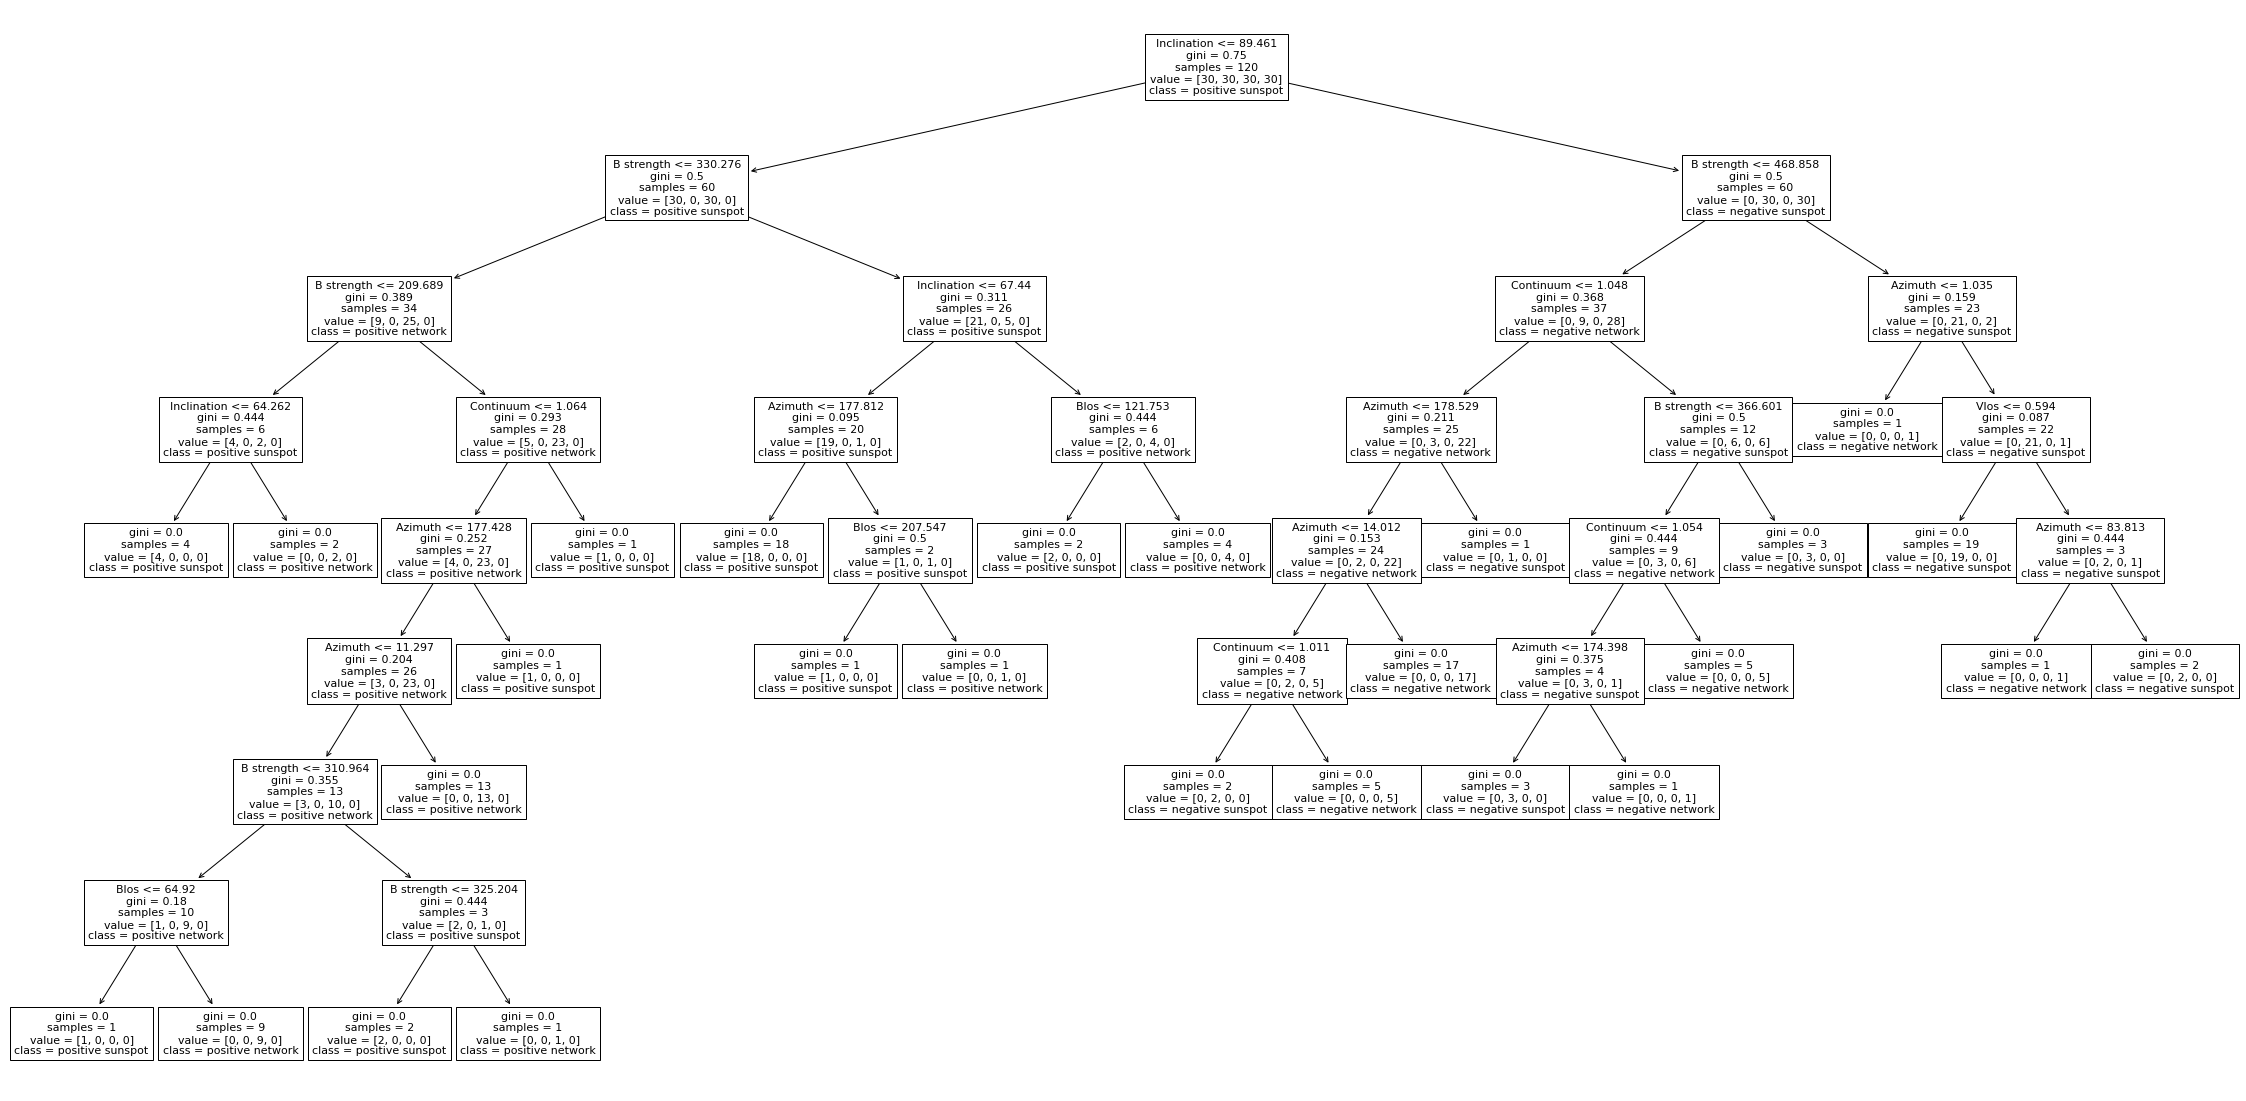

In [127]:
fig = plt.figure(figsize=(40,20))
classes = ['positive sunspot','negative sunspot','positive network','negative network']
band_names = ['Continuum','B strength','Inclination','Azimuth','Vlos','Blos']
plot_tree(dt, feature_names=band_names, class_names=classes)
plt.show()

##Now we want to test the model on the image we have used before to produce the training data. We will apply the model on ALL the pixels in the image to see if the model can predict to which class each pixel belongs.

In [151]:
# (6,2k,2k)--> (2k,2k,6)
map = np.zeros((2048,2048,6))
for i in range(6):
  map[:,:,i] = data_phi[i,:,:]

In [155]:
bands=[]
for i in range(channels):
  temp = map[:,:,i].flatten()
  bands.append(temp)
X_all = np.stack(bands).T

In [156]:
X_all.shape

(4194304, 6)

In [157]:
Y_pred = dt.predict(X_all)
Y_pred.shape

(4194304,)

In [158]:
Y_pred_resh = np.reshape(Y_pred,(2048,2048))

In [160]:
Y_pred_resh.shape

(2048, 2048)

Text(340, 6, 'Negative network')

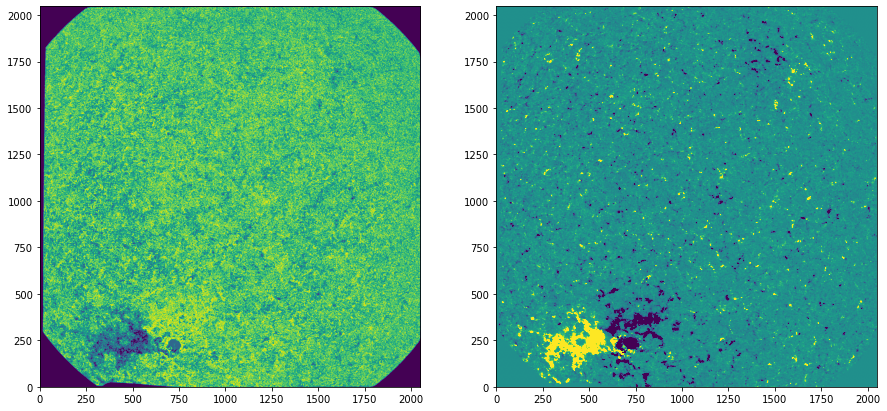

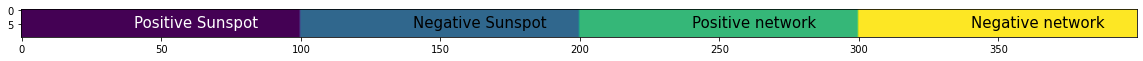

In [176]:
fig1 = plt.figure(figsize=(15,10))
ax1 = fig1.add_subplot(121)
ax1.imshow(Y_pred_resh,origin='lower')
ax2 = fig1.add_subplot(122)
ax2.imshow(data_phi[5,:,:],origin='lower',vmax=50,vmin=-50)

fig = plt.figure(figsize=(20,1))
ax = fig.add_subplot(111)
plt.imshow(np.hstack((np.zeros((10,100)), np.ones((10,100)),2*np.ones((10,100)),3*np.ones((10,100)))))
ax.text(40, 6, 'Positive Sunspot', fontsize=15,  color='white')
ax.text(140, 6, 'Negative Sunspot', fontsize=15,  color='black')
ax.text(240, 6, 'Positive network', fontsize=15,  color='black')
ax.text(340, 6, 'Negative network', fontsize=15,  color='black')

The model does a fair job classifying the different pixels to their corresponding category.